In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import nltk as nltk
import re
import data_cred as cred
import folium
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [150]:
def connect_db(user,password,host,port,database):
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
            
    return connection

In [151]:
def cursor_init(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")  
    return cursor

In [152]:
def select_tuits(topic,cursor):
    #json.dumps(x)
    script = f"Select tweet,topic,city_searched,country_searched FROM data_tweets where topic = '{topic}'"
    cursor.execute(script)
    return cursor

In [153]:
def transform_data(cursor):
    tweets = []
    columns = cursor.description
    for t in cursor.fetchall():
        tweet = t[0]
        tweets.append([tweet['id'], 
                    tweet['full_text'],
                    tweet['retweet_count'],
                    tweet['favorite_count'],
                    tweet['created_at'],
                    tweet['user']['screen_name'], 
                    [i['screen_name'] for i in tweet['entities']['user_mentions']],
                    tweet['user']['description'],
                    tweet['user']['verified'],
                    tweet['user']['location'],
                    tweet['user']['statuses_count'], 
                    tweet['user']['followers_count'], 
                    tweet['user']['friends_count'], 
                    tweet['user']['favourites_count'], 
                    tweet['user']['created_at'], 
                    tweet['user']['profile_image_url'],
                    tweet['user']['created_at'],
                    t[1],
                    t[2],
                    t[3]])

    return tweets

In [154]:
topico_a='trump'
topico_b='biden'
topico_a2='donald trump'
topico_b2='joe biden'
columns = ['id' , 'full_text', 'retweet_count', 'favorite_count', 'created_at', 'user_screen_name' , 'user_mentions', 'user_description', 'user_verified', 'user_location', 'user_statuses_count' , 'user_followers_count' , 'user_friends_count' , 'user_favourites_count' , 'user_created_at' , 'user_profile_image_url', 'user_created_at', 'topic','city_searched','country_searched']

In [155]:
connection = connect_db(cred.database_user,cred.database_pass,"192.168.0.22",'5432','data_tweets')
cursor_a = cursor_init(connection)
cursor_b = cursor_init(connection)

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 



In [156]:
d_a = select_tuits(topico_a, cursor_a)

In [157]:
d_b = select_tuits(topico_b, cursor_b)

In [158]:
data_a = transform_data(d_a)


In [159]:
data_b = transform_data(d_b)


In [160]:
df_a = pd.DataFrame(data_a,columns=columns)
df_b = pd.DataFrame(data_b,columns=columns)


In [161]:
df_a['created_at'] = df_a['created_at'].apply(pd.to_datetime)
df_a['user_created_at'] = df_a['user_created_at'].apply(pd.to_datetime)

In [162]:
df_a.count()[1],df_b.count()[1]

(31050, 6801)

0         1401
1          137
2         9535
3         2472
4         4813
         ...  
30967    17247
30968     1793
30969     2548
30970      779
30971       65
Name: user_followers_count, Length: 30972, dtype: int64

In [163]:
def transform2(text):
    stopWords = set(stopwords.words('spanish'))
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    text = text.lower().replace(' ja ','')
    text = text.lower().replace(' va ','')
    text = text.lower().replace(' si ','')
    text = text.lower().replace(' ser ','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    no_garbage = [w for w in stripped if not w in stopWords]
    return (' '.join(no_garbage))

In [164]:
def transform(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    return (' '.join(stripped))

In [165]:
df_a['tuit_text_transform'] = df_a ['full_text'].apply(transform)
df_b['tuit_text_transform'] = df_b ['full_text'].apply(transform)
df_a['tuit_text_transform2'] = df_a ['full_text'].apply(transform2)
df_b['tuit_text_transform2'] = df_b ['full_text'].apply(transform2)

In [166]:
df_b.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1312819283467141120,Una piba de Estados Unidos conociendo los quil...,0,1,Sun Oct 04 18:18:02 +0000 2020,AzulGasparri,[],24 años| Periodista de deportes| Presidente @A...,False,Buenos Aires,...,170,18687,Thu Jan 30 07:18:24 +0000 2020,http://pbs.twimg.com/profile_images/1288691711...,Thu Jan 30 07:18:24 +0000 2020,biden,Buenos Aires,Argentina,una piba de estados unidos conociendo los quil...,piba unidos conociendo quilombos acáte da mied...
1,1312504109275078656,"Otra excelente edición de este podcast, que ay...",2,12,Sat Oct 03 21:25:39 +0000 2020,patricioviolini,[],Diplomático🇦🇷 | MA in Global Policy @SAISHopki...,False,"Buenos Aires, Argentina",...,3733,1583,Mon Jul 19 18:03:56 +0000 2010,http://pbs.twimg.com/profile_images/1292653291...,Mon Jul 19 18:03:56 +0000 2010,biden,Buenos Aires,Argentina,otra excelente edición de este podcast que ayu...,excelente edición podcast ayuda llenar gap inf...
2,1312501945337180160,Ya vi a @HamillHimself diciendo que no confíen...,0,0,Sat Oct 03 21:17:03 +0000 2020,BarbaraKenobi,[HamillHimself],Cualquiera cosa. XXIV,False,BAires,...,487,32289,Sat Oct 11 13:12:33 +0000 2008,http://pbs.twimg.com/profile_images/1261508051...,Sat Oct 11 13:12:33 +0000 2008,biden,Buenos Aires,Argentina,ya vi a diciendo que no confíen en un político...,vi diciendo confíen político quiere perros dig...
3,1311783801022971904,"Repito, hasta ahora NO he visto ningún argumen...",0,0,Thu Oct 01 21:43:24 +0000 2020,BarbaraKenobi,[],Cualquiera cosa. XXIV,False,BAires,...,487,32289,Sat Oct 11 13:12:33 +0000 2008,http://pbs.twimg.com/profile_images/1261508051...,Sat Oct 11 13:12:33 +0000 2008,biden,Buenos Aires,Argentina,repito hasta ahora no he visto ningún argument...,repito ahora visto ningún argumento económico ...
4,1314164585855946755,"Si gana Biden, perderemos América.",0,0,Thu Oct 08 11:23:47 +0000 2020,solraCDaniel,[],memento mori💀,False,"Buenos Aires, Argentina",...,511,7181,Wed May 05 03:00:08 +0000 2010,http://pbs.twimg.com/profile_images/1187773786...,Wed May 05 03:00:08 +0000 2010,biden,Buenos Aires,Argentina,si gana biden perderemos américa,si gana biden perderemos américa


In [167]:
df_a.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1313630085581287424,Me serví un plato gigante de lasaña de berenje...,0,6,2020-10-06 23:59:53+00:00,marikarne,[],"Kuka, trolo y mostra. El orden puede variar.",False,"Buenos Aires, Argentina",...,296,44349,2012-10-30 23:53:37+00:00,http://pbs.twimg.com/profile_images/1191485751...,2012-10-30 23:53:37+00:00,trump,Buenos Aires,Argentina,me serví un plato gigante de lasaña de berenje...,serví plato gigante lasaña berenjenas puré aho...
1,1313629895432581120,bueno eh se les informa que TRUMP prohibió ste...,0,0,2020-10-06 23:59:07+00:00,_lechuguita_,[],ig: _lechu_diego,False,"Lomas de Zamora, Argentina",...,183,2500,2014-12-23 21:21:11+00:00,http://pbs.twimg.com/profile_images/1252030531...,2014-12-23 21:21:11+00:00,trump,Buenos Aires,Argentina,bueno eh se les informa que trump prohibió ste...,bueno eh informa trump prohibió steam eeuu por...
2,1313629867645251584,@Linxz_7 @realDonaldTrump Trump no jajajaja es...,0,2,2020-10-06 23:59:01+00:00,DonaldOfWallSt,"[Linxz_7, realDonaldTrump]","🇦🇷🇺🇸 Somos seres invencibles, indestructibles ...",False,"Buenos Aires, Argentina",...,1665,10864,2020-08-11 05:09:28+00:00,http://pbs.twimg.com/profile_images/1293211951...,2020-08-11 05:09:28+00:00,trump,Buenos Aires,Argentina,7 trump no estafado por que😞,7 trump estafado que😞
3,1313629211211554816,Que bueno tener un presidente que no meta mied...,0,1,2020-10-06 23:56:24+00:00,Victoria_zz,[],"Historia ,no relato.",False,"Buenos Aires, Argentina",...,4957,23482,2017-10-21 21:55:07+00:00,http://pbs.twimg.com/profile_images/1204251386...,2017-10-21 21:55:07+00:00,trump,Buenos Aires,Argentina,que bueno tener un presidente que no meta mied...,bueno tener presidente meta miedo covid algùn ...
4,1313628857539452929,@donia_trump Mela! es un honor!,0,2,2020-10-06 23:55:00+00:00,celesmonaco,[donia_trump],Amo hacer cheesecakes\nhttps://t.co/F2ChQMJ4UB,False,Buenos Aires,...,905,159451,2012-07-27 21:28:22+00:00,http://pbs.twimg.com/profile_images/1302689050...,2012-07-27 21:28:22+00:00,trump,Buenos Aires,Argentina,trump mela es un honor,trump mela honor


In [168]:
def set_sentiment(text):
    sentiment=0
    text = str(text)
    if text != '':
        analysis = TextBlob(text)
        if len(analysis)>3:
            #if analysis.detect_language() == 'es':
            #analysis = analysis.translate(from_lang='es',to='en').sentiment
            sentiment = analysis.polarity
    return sentiment

In [169]:
df_a['polarity'] = df_a['full_text'].apply(set_sentiment)
df_b['polarity'] = df_b['full_text'].apply(set_sentiment)

In [170]:
df_a['polarity'].describe()

count    31050.000000
mean        -0.000108
std          0.097788
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: polarity, dtype: float64

In [171]:
df_b['polarity'].describe()

count    6801.000000
mean        0.000664
std         0.102609
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polarity, dtype: float64

In [172]:
text_a = ' '.join(df_a.tuit_text_transform2)
text_b = ' '.join(df_b.tuit_text_transform2)
text_a = text_a.lower().replace(topico_a2,'')
text_b = text_b.lower().replace(topico_b2,'')
text_a = text_a.lower().replace(topico_a,'')
text_b = text_b.lower().replace(topico_b,'')
#
text_a = text_a.lower().replace(topico_b2,'')
text_b = text_b.lower().replace(topico_a2,'')
text_a = text_a.lower().replace(topico_b,'')
text_b = text_b.lower().replace(topico_a,'')
#

In [173]:
wordcloud_a = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_a)
wordcloud_b = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_b)

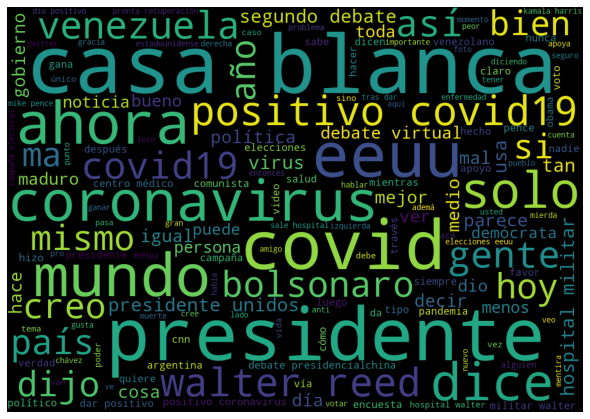

In [174]:
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud_a)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('a_wordcloud.png')
plt.show()


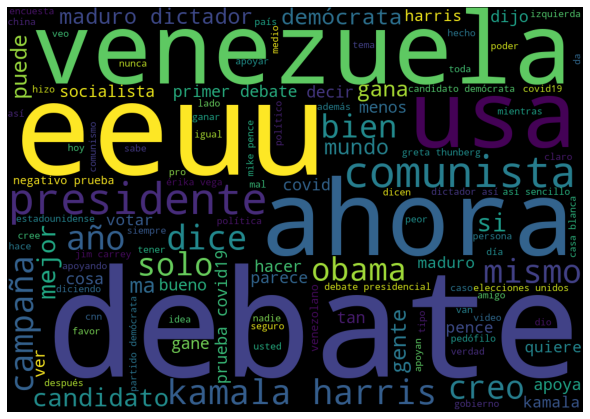

In [175]:
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud_b)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('b_wordcloud.png')
plt.show()


In [177]:
df_af = df_a[df_a['polarity'] != 0] 
df_bf = df_b[df_b['polarity'] != 0] 

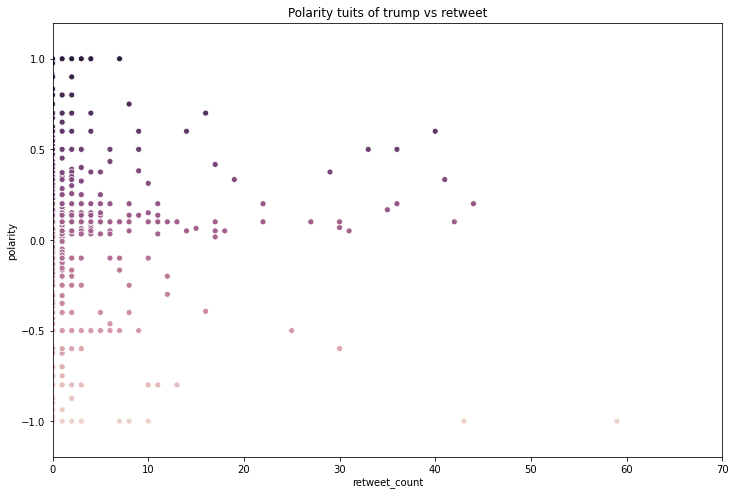

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.title(f'Polarity tuits of {topico_a} vs retweet')
plt.xlim(0,70)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_af, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('a_polarity.png')

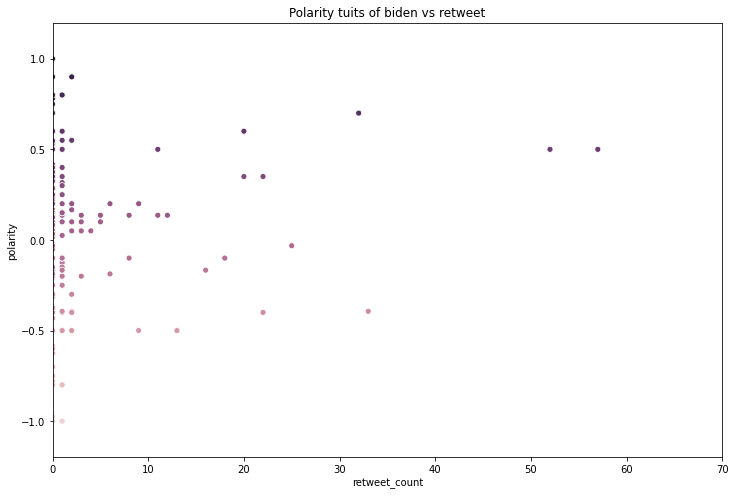

In [188]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.title(f'Polarity tuits of {topico_b} vs retweet')
plt.xlim(0,70)
plt.ylim(-1.2,1.2)
sns.scatterplot(data=df_bf, x='retweet_count', y="polarity", hue="polarity", legend=False, ax=ax)
plt.savefig('b_polarity.png')

In [180]:
def geo_to_number(list_geo):
    geo_return = []
    for geo in list_geo:
        geo = geo.split(',')
        geo = [float(geo[0]),float(geo[1])]
        geo_return.append(geo)
    return list(geo_return)

In [6]:
list_geo = [
'-34.6025287,-58.3796486' ,# buenos aires, argentina
'-23.5861315,-46.6582803', # sao paulo, brasil
'-34.8207362,-56.3765221', #montevideo, uruguay
'-32.8832979,-68.8760287', # mendoza, argentina
'-31.3992876,-64.2643839', #cordoba, argentina
'-31.6145747,-60.6980372', # santa fe, argentina
'7.7721289,-72.226306', # San cristobal , venezuela
'10.2241386,-67.3411383', # La victoria, Aragua , venezuela
'10.4686988,-67.0304528' #caracas, venezuela
]
list_geo = geo_to_number(list_geo)

In [7]:
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

In [10]:
map1 = folium.Map(
    location=[-13.9837562,-56.8230086],
    zoom_start=4,
    #tiles='cartodbpositron',
    tiles='CartoDB dark_matter'
)
i = 0
for geo in list_geo:
    folium.Marker(location=geo, icon=folium.Icon(color=colors[i]) ).add_to(map1)
    #folium.CircleMarker(location=geo).add_to(map1)
    i=i+1
map1